<a href="https://colab.research.google.com/github/Supreeta11/Cardiovascular-Risk-Prediction/blob/main/Cardiovascular_Risk_Prediction_Supreeta_kumari.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importing Required Libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from scipy.stats import chi2, chi2_contingency, f_oneway
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, recall_score, precision_score,\
 accuracy_score, roc_curve, auc, classification_report, confusion_matrix
from xgboost import XGBClassifier
from imblearn.over_sampling import RandomOverSampler, SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from tensorflow.keras import Sequential, layers
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.neighbors import KNeighborsClassifier

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
warnings.filterwarnings('ignore')

In [4]:
#mount drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:

df = pd.read_csv('/content/drive/MyDrive/data_cardiovascular_risk.csv')

In [6]:
df.info

<bound method DataFrame.info of         id  age  education sex is_smoking  cigsPerDay  BPMeds  \
0        0   64        2.0   F        YES         3.0     0.0   
1        1   36        4.0   M         NO         0.0     0.0   
2        2   46        1.0   F        YES        10.0     0.0   
3        3   50        1.0   M        YES        20.0     0.0   
4        4   64        1.0   F        YES        30.0     0.0   
...    ...  ...        ...  ..        ...         ...     ...   
3385  3385   60        1.0   F         NO         0.0     0.0   
3386  3386   46        1.0   F         NO         0.0     0.0   
3387  3387   44        3.0   M        YES         3.0     0.0   
3388  3388   60        1.0   M         NO         0.0     NaN   
3389  3389   54        3.0   F         NO         0.0     0.0   

      prevalentStroke  prevalentHyp  diabetes  totChol  sysBP  diaBP    BMI  \
0                   0             0         0    221.0  148.0   85.0    NaN   
1                   0        

In [7]:
# lets check for distribution of classes
class_0_count, class_1_count = df[df['TenYearCHD']==0].shape[0], df[df['TenYearCHD']==1].shape[0]
print('Class imbalance = %d: %d' % (class_0_count, class_1_count)) # need to address this after some EDA

Class imbalance = 2879: 511


In [8]:
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['TenYearCHD'], random_state = 1)

In [9]:
train_df.shape

(2712, 17)

In [10]:
test_df.shape

(678, 17)

## **Exploratory Data Analysis**

**Categorical Variables**

* Data cleaning-null values imputation





In [41]:
cat_features = ['education', 'sex', 'is_smoking', 'BPMeds', 'prevalentStroke', 'prevalentHyp', 'diabetes']

In [42]:
simp_imputer = SimpleImputer(strategy="most_frequent")
simp_imputer.fit(train_df[cat_features])
train_df[cat_features]= simp_imputer.transform(train_df[cat_features])
test_df[cat_features]= simp_imputer.transform(test_df[cat_features])

## **Education**

In [11]:
train_df.education.unique()

array([ 2.,  3.,  1.,  4., nan])

(array([0, 1, 2, 3]), <a list of 4 Text major ticklabel objects>)

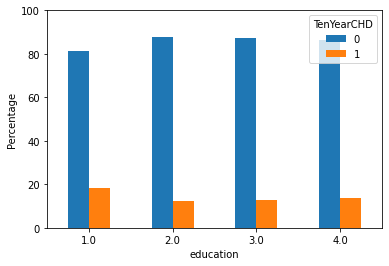

In [12]:
freq_df = train_df.groupby('TenYearCHD')['education'].value_counts().unstack(0)
pct_df = freq_df.divide(freq_df.sum(axis=1), axis=0)*100
pct_df.plot(kind="bar")
plt.ylim(0,100)
plt.ylabel('Percentage')
plt.xticks(rotation=0)

In [13]:
prob = 0.99
alpha = 1.0 - prob

In [14]:
# using chi-square statistic to determine any dependency between categorical variables
def cat_dependency(freq_df, alpha=alpha, verbose=True):
  stat, p, dof, expected = chi2_contingency(freq_df)
  if p <= alpha:
    if verbose:
      print('significance=%.3f, p=%.7f' % (alpha, p))
      print('Categorical variables are dependent')
    return True
  else:
    if verbose:
      print('significance=%.3f, p=%.7f' % (alpha, p))
      print('Categorical variables are not dependent')
    return False

In [15]:
cat_dependency(freq_df)

significance=0.010, p=0.0004690
Categorical variables are dependent


True

## **sex**

(array([0, 1]), <a list of 2 Text major ticklabel objects>)

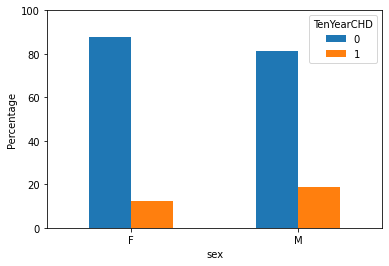

In [17]:
freq_df = train_df.groupby('TenYearCHD')['sex'].value_counts().unstack(0)
pct_df = freq_df.divide(freq_df.sum(axis=1), axis=0)*100
pct_df.plot(kind="bar")
plt.ylim(0,100)
plt.ylabel('Percentage')
plt.xticks(rotation=0)

In [18]:
cat_dependency(freq_df)

significance=0.010, p=0.0000071
Categorical variables are dependent


True

**Higher fraction of males are prone to cardiovascular diseases.**

# **Smoking**

(array([0, 1]), <a list of 2 Text major ticklabel objects>)

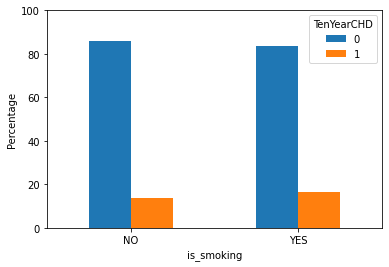

In [19]:
freq_df = train_df.groupby('TenYearCHD')['is_smoking'].value_counts().unstack(0)
pct_df = freq_df.divide(freq_df.sum(axis=1), axis=0)*100
pct_df.plot(kind="bar")
plt.ylim(0,100)
plt.ylabel('Percentage')
plt.xticks(rotation=0)

In [53]:
cat_dependency(freq_df)

significance=0.010, p=0.0928572
Categorical variables are not dependent


False

**statistically smoking has no impact on 10 year risk of CHD**

##**BP Meds**

In [20]:
train_df.BPMeds.unique()

array([ 0.,  1., nan])

(array([0, 1]), <a list of 2 Text major ticklabel objects>)

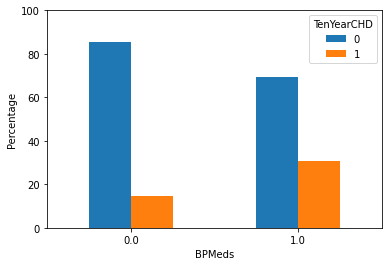

In [21]:
freq_df = train_df.groupby('TenYearCHD')['BPMeds'].value_counts().unstack(0)
pct_df = freq_df.divide(freq_df.sum(axis=1), axis=0)*100
pct_df.plot(kind="bar")
plt.ylim(0,100)
plt.ylabel('Percentage')
plt.xticks(rotation=0)

In [ ]:
cat_dependency(freq_df)

significance=0.010, p=0.0001078
Categorical variables are dependent


True

**People who take Blood Pressure Meds have higher chance of having CHD**

## **Prevalent Stroke**

In [22]:
train_df.prevalentStroke.unique()

array([0, 1])

(array([0, 1]), <a list of 2 Text major ticklabel objects>)

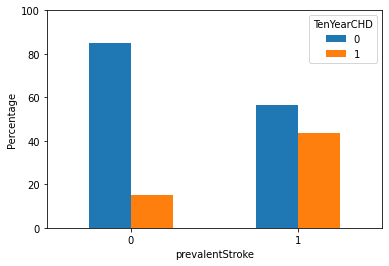

In [23]:
freq_df = train_df.groupby('TenYearCHD')['prevalentStroke'].value_counts().unstack(0)
pct_df = freq_df.divide(freq_df.sum(axis=1), axis=0)*100
pct_df.plot(kind="bar")
plt.ylim(0,100)
plt.ylabel('Percentage')
plt.xticks(rotation=0)

In [24]:
cat_dependency(freq_df)

significance=0.010, p=0.0041885
Categorical variables are dependent


True

**Higher percentage of patients having with prevalent stroke symptoms have a 10-year risk of CHD**

## **Prevalent Hypertension**

In [25]:
train_df.prevalentHyp.unique()

array([0, 1])

(array([0, 1]), <a list of 2 Text major ticklabel objects>)

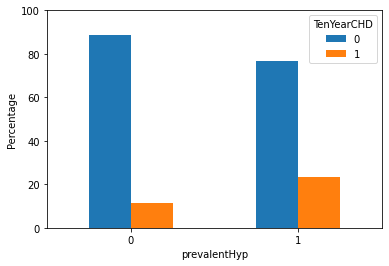

In [26]:
freq_df = train_df.groupby('TenYearCHD')['prevalentHyp'].value_counts().unstack(0)
pct_df = freq_df.divide(freq_df.sum(axis=1), axis=0)*100
pct_df.plot(kind="bar")
plt.ylim(0,100)
plt.ylabel('Percentage')
plt.xticks(rotation=0)

In [27]:
cat_dependency(freq_df)

significance=0.010, p=0.0000000
Categorical variables are dependent


True

**Hypertension patients are having high risk of CHD**

## **Diabetes**

In [28]:
train_df.diabetes.unique()

array([0, 1])

(array([0, 1]), <a list of 2 Text major ticklabel objects>)

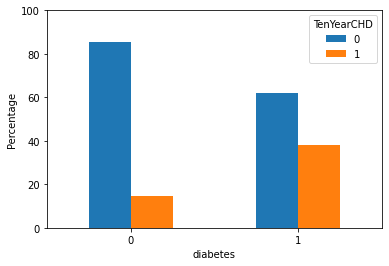

In [29]:
freq_df = train_df.groupby('TenYearCHD')['diabetes'].value_counts().unstack(0)
pct_df = freq_df.divide(freq_df.sum(axis=1), axis=0)*100
pct_df.plot(kind="bar")
plt.ylim(0,100)
plt.ylabel('Percentage')
plt.xticks(rotation=0)

In [30]:
cat_dependency(freq_df)

significance=0.010, p=0.0000004
Categorical variables are dependent


True

**Diabetic patients tends to have higher 10 years risk of CHD**

## **Continuous Variables**

In [31]:
cont_features = ['age', 'totChol', 'cigsPerDay', 'sysBP', 'diaBP', 'BMI', 'heartRate', 'glucose']

In [32]:
knn_imputer= KNNImputer(n_neighbors=5)
knn_imputer.fit(train_df[cont_features])
train_df[cont_features]= knn_imputer.transform(train_df[cont_features])
test_df[cont_features]= knn_imputer.transform(test_df[cont_features])

## **Age**

In [33]:
train_df.age.unique()

array([49., 51., 57., 59., 52., 60., 48., 40., 54., 39., 56., 44., 42.,
       43., 41., 45., 37., 61., 53., 62., 47., 36., 55., 34., 46., 64.,
       38., 58., 63., 35., 50., 65., 67., 66., 68., 33., 69., 70., 32.])

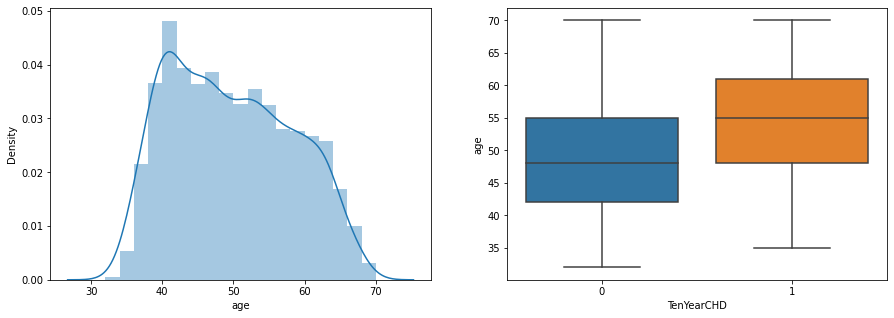

In [34]:
fig, axes = plt.subplots(1,2,figsize=(15,5))
sns.distplot(train_df['age'], ax=axes[0])
sns.boxplot(y='age',x='TenYearCHD',data=train_df, ax=axes[1])

In [35]:
# using one-way ANOVA test to determine dependency between continuous variables and the target categorical variable
def cont_dependency(feature,alpha=alpha):
  F, p = f_oneway(train_df[train_df['TenYearCHD'] == 1][feature], train_df[train_df['TenYearCHD'] == 0][feature])
  print('significance=%.3f, p=%.5f' % (alpha, p))
  if p <= alpha:
    print('Ten year Risk of CHD is dependent on the continuous variable')
    return True
  else:
    print('Ten year Risk of CHD is not dependent on continuous variable')
    return False

In [36]:
cont_dependency('age')

significance=0.010, p=0.00000
Ten year Risk of CHD is dependent on the continuous variable


True

## **Bucketing age features**

In [37]:
train_df['age_bucket'] = train_df['age'].apply(lambda x : 5*(x//5))

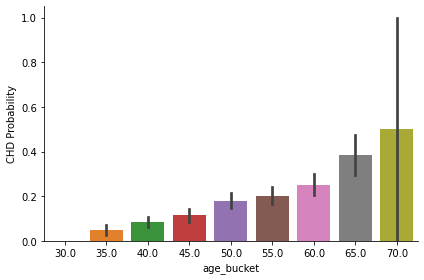

In [38]:
ax=sns.factorplot('age_bucket', 'TenYearCHD', kind='bar', data = train_df, size=4, aspect=1.5)
ax.set_ylabels('CHD Probability')

**The positive CHD cases seems to be more prevalent in older people**

## **Cigrrettes per day**

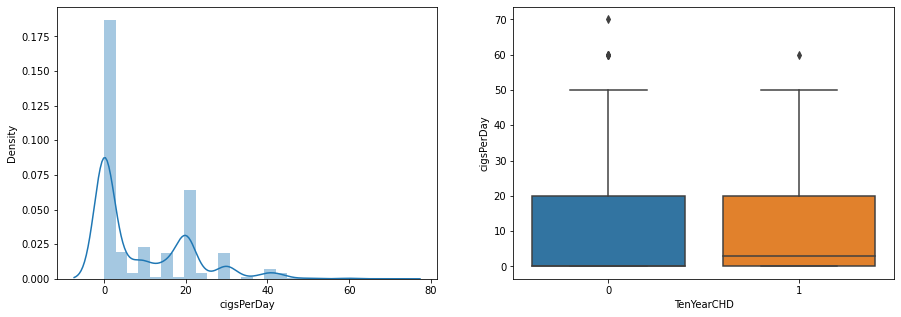

In [39]:
fig, axes = plt.subplots(1,2,figsize=(15,5))
sns.distplot(train_df['cigsPerDay'], ax=axes[0])
sns.boxplot(y='cigsPerDay',x='TenYearCHD',data=train_df, ax=axes[1])

In [40]:
cont_dependency('cigsPerDay')

significance=0.010, p=0.00184
Ten year Risk of CHD is dependent on the continuous variable


True

**We can see that medium is slightly higher for the positive cases,which means people who smoke higher number of cigrattes per day,tend to show cardiovascular**

## **Total Cholerstrol Level**

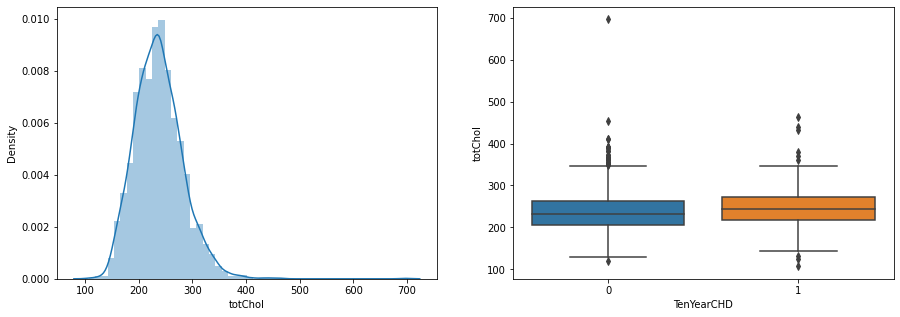

In [41]:
fig, axes = plt.subplots(1,2,figsize=(15,5))
sns.distplot(train_df['totChol'], ax=axes[0])
sns.boxplot(y='totChol',x='TenYearCHD',data=train_df, ax=axes[1])

In [42]:
#dealing with outliers
vals = train_df.totChol.quantile([0.25,0.75])
print(vals)
iqr = vals.values[1] - vals.values[0]
min_lim, max_lim = vals.values[0] - 1.5*iqr, vals.values[1] + 1.5*iqr
train_df['totChol'] = train_df['totChol'].apply(lambda x : x if x > min_lim and x < max_lim else train_df['totChol'].median())

0.25    206.00
0.75    264.25
Name: totChol, dtype: float64


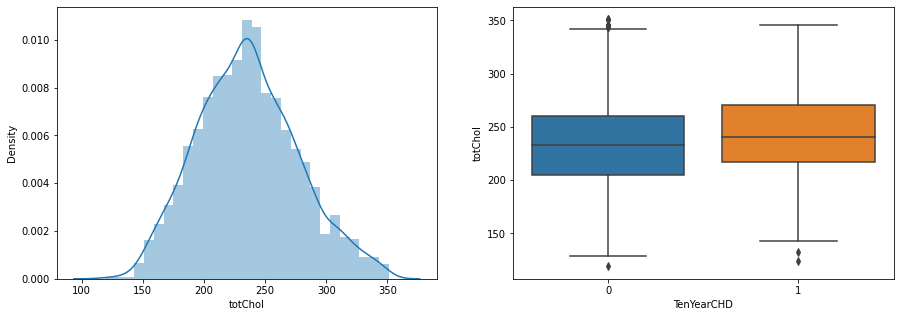

In [43]:
fig, axes = plt.subplots(1,2,figsize=(15,5))
sns.distplot(train_df['totChol'], ax=axes[0])
sns.boxplot(y='totChol',x='TenYearCHD',data=train_df, ax=axes[1])

In [44]:
cont_dependency('totChol')

significance=0.010, p=0.00000
Ten year Risk of CHD is dependent on the continuous variable


True

**Bucketing Total Cholerstrol Feature**

In [45]:
train_df['chol_bucket'] = train_df['totChol'].apply(lambda x : 40*(x//40))

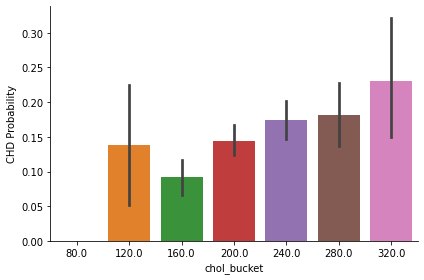

In [46]:
ax = sns.factorplot('chol_bucket', 'TenYearCHD', kind='bar', data = train_df, size=4, aspect=1.5)
ax.set_ylabels('CHD Probability')

## **Systolic & diastolic BP**

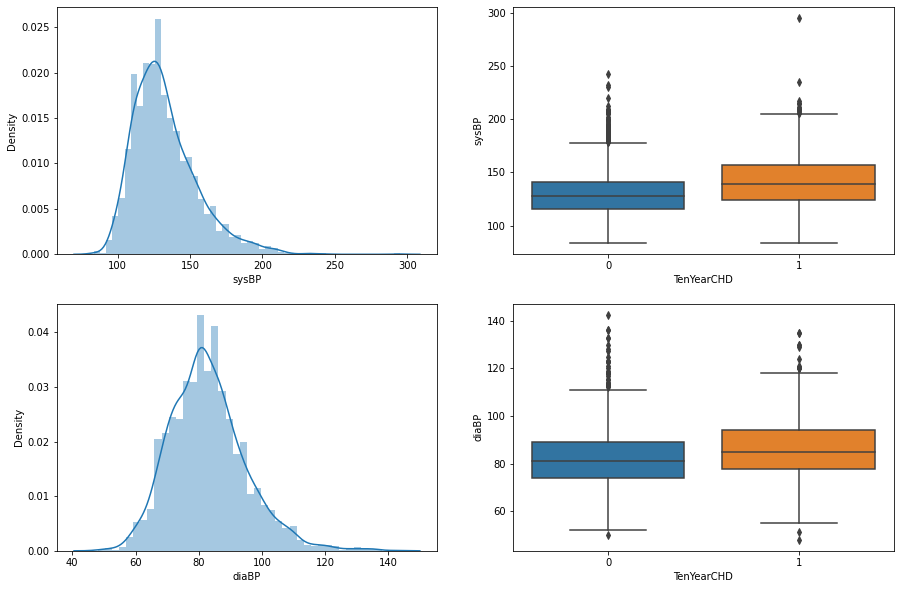

In [52]:
fig, axes = plt.subplots(2,2,figsize=(15,10))
sns.distplot(train_df['sysBP'], ax=axes[0,0])
sns.boxplot(y='sysBP',x='TenYearCHD',data=train_df, ax=axes[0,1])
sns.distplot(train_df['diaBP'], ax=axes[1,0])
sns.boxplot(y='diaBP',x='TenYearCHD',data=train_df, ax=axes[1,1])

In [48]:
cont_dependency('sysBP')

significance=0.010, p=0.00000
Ten year Risk of CHD is dependent on the continuous variable


True

In [49]:
cont_dependency('diaBP')

significance=0.010, p=0.00000
Ten year Risk of CHD is dependent on the continuous variable


True

**Bucketing Systolic BP Feature**

In [50]:
train_df['sysBP_bucket'] = train_df['sysBP'].apply(lambda x : 30*(x//30))

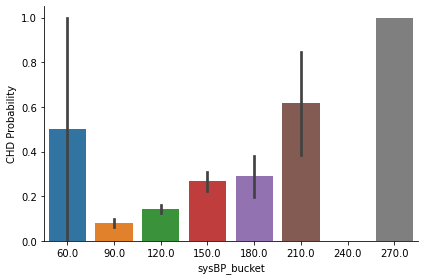

In [51]:
ax = sns.factorplot('sysBP_bucket', 'TenYearCHD', kind='bar', data = train_df, size=4, aspect=1.5)
ax.set_ylabels('CHD Probability')

**We see a slightly positive inclination of CHD risk towards high systolic & diastolic Blood Pressure**

##**Body Mass Index(BMI)**